# Time Series Classification

Short description

- Topic: Time Series Classification (TSC)
- Goal: collect concise notes, references, and practical commands for learning and experimenting with TSC algorithms and libraries.

---

## Overview

Time series classification applies supervised machine learning to labeled temporal data: models learn from examples of different classes and then predict the class of new series. This is essential for tasks like sensor monitoring or financial analysis, where correct, reliable predictions directly affect business decisions.

## Problem types / when to use

- Univariate vs multivariate time series
- Single-label classification (one label per series)
- Multi-label or sequence labeling (per-timestep labels)

``** Use time series classification when your input is ordered temporal data and the goal is to predict a discrete class for the sequence.``

## Types of time series classification

Below is a concise list of common classification types. Each line links to a short, detailed description further down.

1. [Distance-based](#distance-based) — compare series using a distance metric (e.g., DTW) with instance-based classifiers (k-NN).
2. [Shapelet](#shapelet) — discover discriminative subsequences (shapelets) that separate classes.
3. [Model ensembles](#model-ensembles) — combine multiple classifiers (often heterogeneous) for robust performance (e.g., HIVE‑COTE).
4. [Dictionary approach](#dictionary-approach) — convert series to symbolic words and classify using bag-of-words techniques (SAX, BOSS).
5. [Interval-based approach](#interval-based-approach) — extract features from random or selected intervals and classify using feature-based learners.
6. [Deep learning](#deep-learning) — end-to-end learning with CNNs/RNNs/Transformers to automatically extract discriminative features.

### Distance-based

Distance-based methods use a numeric **distance** to quantify how similar two time series are. The smaller the distance, the more similar the series. Common distance measures used in ML include **Euclidean**, **Manhattan**, **Minkowski**, and **Hamming** distances — but for time series we often need measures that tolerate time shifts and local misalignments, which is where **Dynamic Time Warping (DTW)** shines.

How distance-based classification works (typical **k‑NN** flow):

- **Normalize** series (usually **z-normalization**) to remove scale/offset differences.
- Compute **distances** between the test series and every training series using a chosen metric.
- Select the **k** training series with the smallest distances.
- Assign the test series the majority class among those **k** neighbors (**k=1** gives **1‑NN**).

Notes on distance metrics and algorithms:

- **Euclidean** / **Manhattan** / **Minkowski**: simple pointwise distances; efficient but sensitive to small time shifts.

- **Hamming**: for discrete/symbolic sequences; counts mismatches at aligned positions.

- **Kernel / SVM** relation: kernel methods (e.g., **SVM**) can incorporate similarity information — a kernel can be built from a distance or similarity measure so that the classifier uses pairwise similarities (think of an **SVM** with a custom kernel derived from a distance matrix).

Why **DTW** is special for time series:

  - **DTW** aligns two sequences by warping the time axis to find the minimum cumulative distance (warping path) between them; this handles local speed/phase differences (e.g., the same pattern occurs slightly earlier/later).

  - **DTW** computes a cost matrix and a minimal-cost path through it. Complexity is **O(n\*m)** for series lengths n and m; common speedups include limiting the **warping window** (Sakoe–Chiba / Itakura constraints) and using lower bounds (**LB_Keogh**) to prune comparisons.

  - In practice, **DTW + 1‑NN** has been a strong baseline for many TSC tasks and is commonly used in benchmarks.
  



*Example:*

  * Comparing two people walking:
    - **Sequence A (Person A)**: [Walk, Rest, Walk, Rest]
    - **Sequence B (Person B)**: [Rest, Walk, Rest, Walk]
    - Essentially, both people exhibit the same behavior (2 steps of walking, 2 beats of resting), but Person B simply starts 1 beat later.

  1. **Using Euclidean Distance (Pointwise Comparison):**
    - Euclidean compares rigidly, point-by-point:
      - T1: (A Walk) vs (B Rest) → Different!
      - T2: (A Rest) vs (B Walk) → Different!
      - T3: (A Walk) vs (B Rest) → Different!
      - T4: (A Rest) vs (B Walk) → Different!
    - **Conclusion by Euclidean**: These sequences are completely different (large distance).

  2. **Using Hamming Distance (Pointwise Comparison):**

      * Hamming distance rigidly counts the mismatches at each corresponding position:

        * **T1:** (A `Walk`) vs (B `Rest`) $\rightarrow$ Mismatch! (Count = 1)
        * **T2:** (A `Rest`) vs (B `Walk`) $\rightarrow$ Mismatch! (Count = 2)
        * **T3:** (A `Walk`) vs (B `Rest`) $\rightarrow$ Mismatch! (Count = 3)
        * **T4:** (A `Rest`) vs (B `Walk`) $\rightarrow$ Mismatch! (Count = 4)

      - **Conclusion by Hamming:** These sequences are **completely different**. The Hamming distance is 4, which is the maximum possible distance for sequences of this length, implying zero similarity.

  3. **Using DTW (Dynamic Time Warping):**
    - DTW is smarter. It "warps" the time axis to find the best alignment:
      - (A Walk at T1) aligns with (B Walk at T2).
      - (A Rest at T2) aligns with (B Rest at T3).
      - (A Walk at T3) aligns with (B Walk at T4).
    - **Conclusion by DTW**: These sequences are very similar, just slightly misaligned (phase-shifted).

  This example highlights why DTW is particularly effective for time series data, as it can handle local shifts in time and still identify underlying similarities.

### 📊 Bảng so sánh các phương pháp đo lường

| Phương pháp | Loại dữ liệu chính | Cách hoạt động (Đơn giản) | Điểm mạnh / Điểm yếu |
| :--- | :--- | :--- | :--- |
| **Euclidean / Manhattan** | Dữ liệu số, liên tục | So sánh **1-đối-1** tại *cùng một thời điểm*. (Điểm `T1` của A vs. Điểm `T1` của B) | **(+)** Rất nhanh, hiệu quả.<br> **(-)** **Rất nhạy cảm** nếu dữ liệu bị lệch (shift) dù chỉ một chút. |
| **Hamming** | Dữ liệu rời rạc, ký hiệu | Đếm số lượng vị trí mà hai chuỗi *không khớp* nhau. (Ví dụ: `A,B,C` vs `A,B,D` có 1 điểm không khớp) | **(+)** Tốt cho dữ liệu dạng ký tự, gen, v.v.<br> **(-)** Không dùng được cho dữ liệu số liên tục (như nhiệt độ). |
| **DTW (Dynamic Time Warping)** | Dữ liệu số, liên tục | So sánh **1-đối-nhiều**. Nó "co giãn" thời gian để tìm cách căn chỉnh (align) tốt nhất. | **(+)** **Cực kỳ tốt** cho các chuỗi bị lệch pha/tốc độ.<br> **(-)** Tính toán chậm và tốn kém hơn (phức tạp O(n*m)). |
| **Kernel (dùng trong SVM)** | Bất kỳ (tùy kernel) | Đây là một *mô hình*, không phải phép đo. Nó dùng một "kernel" (có thể dựa trên DTW) để biến đổi dữ liệu. | **(+)** Rất mạnh mẽ để phân loại.<br> **(-)** Phức tạp hơn, không chỉ là một phép đo khoảng cách. |

Practical tips and pitfalls:

- Always **z-normalize** series before **DTW** or **Euclidean** comparisons — otherwise scale dominates the distance.

    * Z-normalization is a preprocessing step that standardizes a time series to have a mean of 0 and a standard deviation of 1. This allows algorithms like DTW to compare data based on shape rather than differences in scale or offset.
    $$z = \frac{x - \mu}{\sigma}$$

            **example:
                x1  x2  x3      x'1    x'2  x'3
            A: [26, 27, 26] -> [-0.33, 0.667, -0.33]
            B: [36, 37, 36] -> [-0.33, 0.667, -0.33]

                                        A     B
            * μ = (x1 + x2 + x3)/3 = [26.33,36,33]
            * σ = 1

- Use a **warping window** (e.g., 5–10% of series length) to avoid pathological warpings and speed up computation.

    * A "warping window" (e.g., 10% of series length) is a constraint added to DTW. Instead of calculating the entire $n \times m$ cost matrix, it only computes a small "band" around the diagonal.

        * **Benefit 1 (Speed):** Drastically speeds up computation from $O(n \times m)$ to $O(n \times r)$ (where $r$ is the window size).
        * **Benefit 2 (Accuracy):** Prevents "pathological warping" (unrealistic stretching/compressing of time) by forcing matches to stay relatively close. (ex: $|i - j| \le r$)

- For large datasets, compute and cache pairwise distances or use approximate methods / lower bounds (**LB_Keogh**) to prune.

    * Pruning is a "skip" strategy used to speed up search algorithms like KNN. Instead of performing the **slow, expensive** distance calculation (like DTW) for *every* item in the dataset, it uses a **fast, simpler** "proxy" calculation (a Lower Bound) to quickly eliminate candidates.

    * The logic is: If the *fast proxy distance* is already worse than the best match you've found so far, you can **"prune" (safely discard)** that candidate without ever running the slow calculation.

    * Key Advantages

        * **Massive Speedup:** It dramatically reduces the total number of expensive calculations required, often by over 99%. This makes KNN-DTW feasible on large datasets that would otherwise be computationally impossible.
        * **Guaranteed Accuracy:** When used correctly (with a true lower bound), pruning is an **exact** optimization, *not* an approximation. The final result (the nearest neighbor) is **guaranteed to be the same** as if you had run the full, slow brute-force search.
        
                Q = [1, 3, 2, 4]
                C = [3, 4, 1, 5]
                r = 1
            
        |  i | C[i] | L[i] = min(Q[i - r, i + r]) | U[i] = max(Q[i - r, i + r]) | Kiểm tra | Phí phạt (Cost) |
        | :--- | :--- | :--- | :--- | :--- | :--- |
        | **0** | **3** | `min(Q[0,1]) = min(1,3)` = **1** | `max(Q[0,1]) = max(1,3)` = **3** | `1 <= 3 <= 3` (Trong hầm) | 0 |
        | **1** | **4** | `min(Q[0..2]) = min(1,3,2)` = **1** | `max(Q[0..2]) = max(1,3,2)` = **3** | `4 > 3` (Vọt trần) | `(4 - 3)² = 1` |
        | **2** | **1** | `min(Q[1..3]) = min(3,2,4)` = **2** | `max(Q[1..3]) = max(3,2,4)` = **4** | `1 < 2` (Đâm sàn) | `(2 - 1)² = 1` |
        | **3** | **5** | `min(Q[2,3]) = min(2,4)` = **2** | `max(Q[2,3]) = max(2,4)` = **4** | `5 > 4` (Vọt trần) | `(5 - 4)² = 1` |
        | **Tổng** | | | | **Tổng Khoảng cách (LB\_Keogh)** | **0 + 1 + 1 + 1 = 3** |

- Consider **derivative DTW** or **weighted DTW** variants if amplitude vs. shape matters.

  1. Derivative DTW (DDTW)

  **Idea:**
Instead of comparing the absolute values `A[i]` vs. `B[j]`, this algorithm compares their *derivatives* (estimated slopes) at those points (e.g., `(A[i] - A[i-1])` vs. `(B[j] - B[j-1])`).

  **What it Solves:**
It completely ignores differences in "offset" (baseline shift). The two series `[1, 2, 3]` and `[101, 102, 103]` would have a DDTW distance of nearly 0, as they both have the same *slope* (a constant increase of 1).

  **When to Use:**
When **shape** and **trend** are the only things that matter, and the absolute amplitude (value) is irrelevant or misleading. (e.g., gesture recognition, signature matching).

  2. Weighted DTW (WDTW)

  **Idea:**
  This is standard DTW, but it adds a "weight" to the distance calculation at each point, often based on amplitude. The formula becomes: `Cost = Weight(i, j) * (A[i] - B[j])²`.

  **What it Solves:**
  It addresses the problem that "not all points are equally important." It heavily penalizes misalignments at peaks or valleys and cares less about errors along the flat baseline.

  **When to Use:**
  When **both shape and amplitude matter**, and you specifically want to ensure that high-amplitude events (like ECG peaks, stock price spikes) are aligned correctly.

Small runnable example (**DTW + 1‑NN** using `tslearn` + scikit-learn):

In [ ]:
pip install numpy tslearn matplotlib scikit-learn h5py 

Prediction Class: perfect sin
Nearest Neighbor Index: 0 (Label: perfect sin)


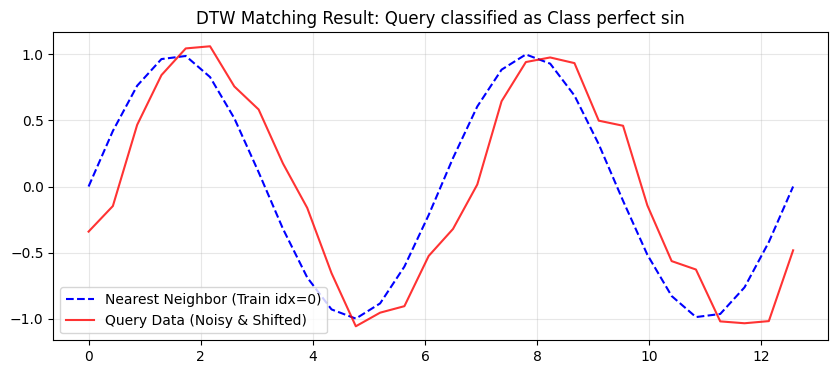

In [22]:
# Install libraries if missing:
# !pip install numpy tslearn matplotlib scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

# ==========================================
# 1. DATA PREPARATION (Giả lập dữ liệu)
# ==========================================

# Cấu hình dữ liệu
N_POINTS = 30           # Độ phân giải: 30 điểm dữ liệu/mẫu
CYCLES = 4 * np.pi      # 4*pi = 2 chu kỳ sóng đầy đủ (vì 1 chu kỳ = 2*pi)
                        # -> Giúp tạo dữ liệu đủ phức tạp để test độ khớp

# Tạo trục thời gian
t = np.linspace(0, CYCLES, N_POINTS)

# --- Training Set ---
# Tạo 3 mẫu: 2 mẫu hình SIN (Class 0) và 1 mẫu đường thẳng (Class 1)
X_train_raw = [
    np.sin(t),                 # Mẫu 0: Sin chuẩn
    np.sin(t + 0.5),           # Mẫu 1: Sin lệch pha (Shifted left). DTW xử lý tốt cái này.
    np.linspace(0, 0, N_POINTS)# Mẫu 2: Đường thẳng (Flat line)
]
y_train = ["perfect_sin", "shifted_sin", "flat_line"]            # Nhãn tương ứng cho các mẫu trên

# --- Query (Test) Data ---
# Tạo một mẫu Sin mới, bị lệch pha và có nhiễu
# - (t - 0.5): Lệch pha ngược chiều so với mẫu 1 -> Thử thách DTW co giãn
# - np.random.normal(...): Thêm nhiễu Gaussian để mô phỏng cảm biến thực tế (không bao giờ mượt 100%)
query_raw = np.sin(t - 0.5) + np.random.normal(0, 0.1, N_POINTS)

# Format lại dữ liệu theo chuẩn của tslearn (n_samples, sz, d)
X_train = to_time_series_dataset(X_train_raw)
X_query = to_time_series_dataset([query_raw])

# ==========================================
# 2. MODELING (Cách Dev thường làm)
# ==========================================
# Sử dụng KNeighborsTimeSeriesClassifier của tslearn.
# Đây là wrapper tối ưu, hỗ trợ metric="dtw" ngay lập tức.
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")

# Train (Lưu dữ liệu vào memory)
knn_clf.fit(X_train, y_train)

# Predict
prediction = knn_clf.predict(X_query)

# ==========================================
# 3. VISUALIZATION & LOGGING
# ==========================================
# Lấy ra index của hàng xóm gần nhất để verify
neighbor_idx = knn_clf.kneighbors(X_query, return_distance=False)[0][0]

print(f"Prediction Class: {prediction[0]}")
print(f"Nearest Neighbor Index: {neighbor_idx} (Label: {y_train[neighbor_idx]})")

# Vẽ hình so sánh
plt.figure(figsize=(10, 4))
plt.plot(t, X_train[neighbor_idx].ravel(), 'b--', label=f"Nearest Neighbor (Train idx={neighbor_idx})")
plt.plot(t, query_raw, 'r-', alpha=0.8, label="Query Data (Noisy & Shifted)")
plt.title(f"DTW Matching Result: Query classified as Class {prediction[0]}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

When to choose distance-based methods:

  * Distance-based approaches (typically **k-Nearest Neighbors**) classify time series by measuring the global similarity between a test sample and labeled training samples.

    * **Global Similarity Focus:** Use when the class is defined by the **overall shape or pattern** of the entire series, rather than specific small sub-patterns (shapelets) or complex abstract features.
    * **Low Data Regimes:** Highly effective when training data is scarce, as there are no complex parameters to learn (unlike Deep Learning).
    * **Interpretability:** Ideal when you need to explain *why* a classification was made by showing the "nearest neighbors" (similar historical examples).
    * **"Lazy" Learning:** Useful when you need to add new data to the training set frequently without retraining a model (since there is no training phase).

  * Metric Selection Guide:
    * **Euclidean:** Use for fixed-length, perfectly aligned continuous data (fastest).
    * **DTW:** Use for continuous data with phase shifts or speed variations (most accurate).
    * **Hamming / Edit Distance:** Use for **discrete** or symbolic sequences (e.g., DNA, text, log events).

### Shapelet

#### 1. How it works

Unlike distance-based methods that compare the _entire_ time series (like DTW or Euclidean), this approach focuses on **local subsequences**.

1.  **Discovery:** The algorithm scans the training data to find **subsequences** (short segments) that best discriminate between classes. These discriminative subsequences are called **Shapelets**.
2.  **Transformation:**
    - For a new time series, the algorithm "slides" the Shapelet along the entire series.
    - It calculates the Euclidean distance at every position.
    - The **Minimum Distance** found is kept.
3.  **Classification:** This "minimum distance" value becomes a new feature. These features are then fed into a standard classifier (like a Linear Classifier or Random Forest) to predict the class.

#### 2. Note

- `Shapelet Transform: This process converts raw Time Series data into a vector of distances. For example, if the model learns 5 shapelets, each time series is transformed into a vector of 5 numbers (the distances to those 5 shapelets).`

##### The Concept: Dimensionality Reduction
Instead of analyzing the entire raw time series (which might be hundreds of points long), the algorithm summarizes the series based on **how well it matches** a specific set of learned patterns (Shapelets).

##### The Metaphor: A Medical Checklist
Imagine the Time Series is a **Patient** and the Shapelets are a list of **5 Symptoms** (e.g., Cough, Fever, Rash, etc.).
Instead of recording the patient's entire biological history, a doctor simply notes the presence or absence of these 5 symptoms.

* **Raw Data:** The patient's history (Complex & Long).
* **Shapelets:** The 5 specific symptoms to look for.
* **Vector of Distances:** The checklist results.

##### Technical Step-by-Step
Assume we have a raw Time Series $T$ (length 100) and the model has learned **5 Shapelets** ($S_1$ to $S_5$).

1.  **Scan & Measure:** The algorithm slides $S_1$ across $T$ to find the *best local match* (minimum Euclidean distance).
    * *Result:* It finds a very similar segment. Distance = **0.5**.
2.  **Repeat:** It does the same for $S_2$.
    * *Result:* It finds no similar segment. Distance = **100.2**.
3.  **Compile:** It repeats this for all 5 shapelets.

##### The Transformation Result
The data is transformed from a temporal sequence into a simple feature vector (a list of coordinates):

* **Input (Raw Time Series):** `[12, 15, 11, 20, ..., 5]` (Length: 100)
* **Output (Feature Vector):** `[0.5, 100.2, 12.1, 3.4, 88.0]` (Length: 5)

##### Why do this?
The resulting vector acts as a new set of coordinates for the data:
* **Low Value (0.5):** Indicates the series **contains** the pattern $S_1$.
* **High Value (100.2):** Indicates the series **does not contain** the pattern $S_2$.

**Benefit:** This simple vector of 5 numbers can now be fed into standard, efficient machine learning classifiers (like Random Forest, SVM, or Logistic Regression), which handle vectors well but cannot handle raw time series data directly.
    



- `A Shapelet does not need to be the same length as the original time series; it is typically much shorter.`

#### 3. Why it is special

- **Interpretability:** This is its strongest advantage. You can point to a specific segment on a plot and say: _"This series is classified as 'Heart Disease' because it contains this specific pattern (shapelet) that matches the disease signature."_ Deep Learning or global DTW cannot provide this level of granular explanation.
- **Noise Resistance:** Because it looks for the "best local match," it effectively ignores noise or irrelevant distortions in the rest of the time series.
    ### ❓ Clarification: Is Euclidean Distance sensitive to noise?

    **User Doubt:** Since Shapelets use Euclidean distance (point-to-point), shouldn't they be highly sensitive to noise?

    **Answer:**
    Yes, Euclidean distance is sensitive to pointwise noise. However, the "Noise Resistance" of Shapelets refers to **Global Resistance**, not Pointwise Resistance.

    1.  **Ignoring "Background" Noise:** The primary strength is the **Minimum Distance** mechanism. If a time series is 90% noise and 10% signal, the algorithm slides the shapelet across. It finds the matching 10% (low distance) and **discards** the high distance values calculated from the 90% noisy background.
        * *Key phrase:* "Ignores distortions in the **rest** of the time series."

    2.  **Handling "Local" Noise:** For noise within the matching segment itself:
        * **Z-Normalization:** Subsequences are typically Z-normalized before comparison, removing amplitude/offset noise.
        * **Shape Dominance:** Unless the noise is so extreme that it destroys the shape (e.g., a spike becomes a flat line), the Euclidean distance of a "noisy match" will still be significantly lower than that of a "non-match."

#### 4. Example

**ECG Diagnosis (Electrocardiogram):**

- **Class A (Normal):** Regular heartbeat.
- **Class B (Pathology):** Mostly regular, but occasionally exhibits a specific **small dip** (e.g., ST-depression) lasting 0.5 seconds.
- **The Shapelet:** The algorithm learns that this specific "dip" shape is the key discriminator.
- **Detection:** When scanning an hour-long ECG, as soon as it finds a segment that matches this "dip" (low distance), it flags the series as pathological, regardless of the rest of the signal.

#### 5. Practical tips and pitfalls

- **Pitfall (Computational Cost):** Finding shapelets using a brute-force search is extremely computationally expensive ($O(N^2 M^4)$).
- **Tip:** Use optimized libraries like `tslearn` which implements **"Learning Shapelets"**. This method learns the shapelets via Gradient Descent (similar to training a neural network) rather than searching for them, which is significantly faster.
- **Tip:** The number of shapelets (`n_shapelets`) and their length (`sz`) are critical hyperparameters that need tuning.

#### 6. When to choose

1.  **Local Features:** When the class is defined by a specific, short event (a spike, a dip, a specific cycle) rather than the global shape.
2.  **Explainability Required:** In fields like healthcare, engineering, or finance where you must explain _why_ a decision was made.
3.  **High Background Noise:** When the majority of the time series is irrelevant noise, and the signal is contained in a small segment.

## 7. Runnable Example

In [ ]:
# Run this cell to install packages required by the shapelet example (cell 17)
# Use %pip to ensure the notebook's environment is used.
# %pip install --upgrade pip
%pip install numpy matplotlib tslearn tensorflow

C:\Users\qwsde\AppData\Roaming\Python\Python313\site-packages\tslearn\shapelets\shapelets.py:492: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/1000


C:\Users\qwsde\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'min_pooling_0' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7025
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7025
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7025
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7025
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7024
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7024
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6870 - loss: 0.7024
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6870 - loss: 0.7024
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━

C:\Users\qwsde\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'min_pooling_0' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


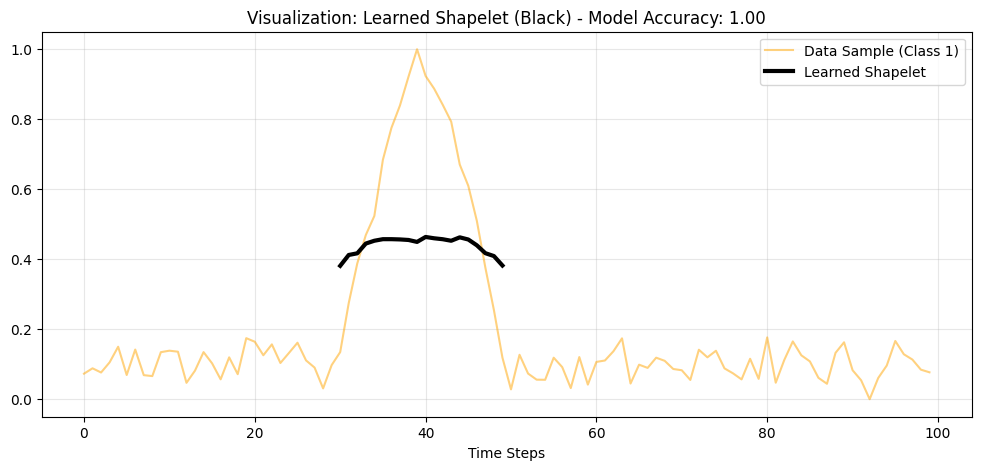

Observation: The black line should now curve to match the 'bump'.


In [4]:
# Requires: pip install tslearn tensorflow
import numpy as np
import matplotlib.pyplot as plt
from tslearn.shapelets import LearningShapelets
from tslearn.preprocessing import TimeSeriesScalerMinMax

# ==========================================
# 1. SYNTHETIC DATA GENERATION (Improved)
# ==========================================
np.random.seed(42)
n_samples = 200  # <--- MODIFICATION 1: Increased from 50 to 200 samples
time_steps = 100

X = np.zeros((n_samples, time_steps, 1)) 

    # x => shape: [ 
    #               A1: [ A1,1: [0], A1,2: [0], ..., A1,100: [0] ],
    #               A2: [ A2,1: [0], A2,2: [0], ..., A2,100: [0] ],
    #               ... ,
    #               A200: [ A200,1: [0], A200,2: [0], ... , A200,100: [0] ]
    #             ]
    # shape: time series
    # A1: time series sample 1
    # A1,1: time step 1 of sample 1
    # A1,1,0: feature 0 of time step 1 of sample 1 (univariate => only 1 feature per time step)
            
y = np.zeros(n_samples)

    # y => shape: [ C1, C2, ..., C200 ]
    # Ci: class label of sample i

for i in range(n_samples):
    # Generate background noise
    X[i, :, 0] = np.random.normal(0, 0.1, time_steps)
        # i=0: sample 1 => X[0, :, 0] = [ x0,1,val, x0,2,val, ..., x0,100,val ]
        
    
    if i >= n_samples // 2:  # Second half belongs to Class 1
        y[i] = 1
        # Inject a "Bell-shaped Bump" at a random position
        start = np.random.randint(10, 80) # Ensure the bump fits within the time series
        # This sine wave segment is the "discriminative feature"
        X[i, start:start+20, 0] += np.sin(np.linspace(0, np.pi, 20)) * 2
        # i=150: sample 151 => X[150, x: x+20, 0] = [ x150,1,val, x150,2,val, ..., x150,100,val ]

# Normalize data
scaler = TimeSeriesScalerMinMax()
X = scaler.fit_transform(X)

# ==========================================
# 2. TRAIN LEARNING SHAPELETS MODEL (Tuned)
# ==========================================
# We ask the model to learn exactly 1 shapelet of length 20
shp_clf = LearningShapelets(n_shapelets_per_size={20: 1},
                            max_iter=1000,          # <--- MODIFICATION 2: Increased iterations (give it time to learn)
                            verbose=1,              # Set to 1 to see the loss decreasing
                            scale=False,
                            random_state=42,         
                            weight_regularizer=0.01) # <--- MODIFICATION 3: Reduce regularization to allow "curvy" shapes
shp_clf.fit(X, y)

# ==========================================
# 3. VISUALIZATION
# ==========================================
predicted_locations = shp_clf.locate(X) 

plt.figure(figsize=(12, 5))
plt.title(f"Visualization: Learned Shapelet (Black) - Model Accuracy: {shp_clf.score(X, y):.2f}")

# Dynamic Sample Selection: Find a valid sample from Class 1 to plot
# Instead of hardcoding '30', we find the first index where y == 1
idx_sample = np.where(y == 1)[0][0] 

# Plot the data sample (Orange)
plt.plot(X[idx_sample].ravel(), color='orange', label='Data Sample (Class 1)', alpha=0.5)

# Plot the learned shapelet (Black) at the correct position
learned_shapelet = shp_clf.shapelets_[0]
start_pos = predicted_locations[idx_sample, 0]

if start_pos < time_steps:
    t_range = range(start_pos, start_pos + len(learned_shapelet))
    plt.plot(t_range, learned_shapelet, color='black', linewidth=3, label='Learned Shapelet')

plt.legend()
plt.grid(True, alpha=0.3)
plt.xlabel("Time Steps")
plt.show()

print("Observation: The black line should now curve to match the 'bump'.")

### Model ensembles

    Ensemble approaches combine multiple classifiers (often heterogeneous: distance-based, interval-based, feature-based) to produce a robust final prediction. Examples: HIVE‑COTE and related ensembles. Pros: strong accuracy across varied problems. Cons: heavy computational and memory cost; more complex to interpret.

### Dictionary approach

    Dictionary (bag-of-patterns) methods transform time series into sequences of discrete symbols (e.g., SAX), build a vocabulary of "words" from subsequences, and then classify using frequency-based features (BOSS, Word Bag approaches). They are efficient and effective for pattern frequency differences, but may lose fine-grained temporal alignment.

### Interval-based approach

    Interval methods randomly or strategically select sub-intervals from series, extract summary features (mean, slope, std, etc.) per interval, and feed those features to traditional classifiers (e.g., Time Series Forest). These methods capture local behaviour with lower complexity than exhaustive subsequence search.

### Deep learning

    Deep models (1D CNNs, RNNs/LSTMs, and Transformers) learn hierarchical features directly from raw series, enabling powerful end-to-end classification. They scale well with data size and can capture complex temporal dependencies, but require more data and hyperparameter tuning, and are less interpretable by default.

## Libraries & tools

- Python:
  - `sktime` — unified framework for time series ML (classification, forecasting)
  - `tslearn` — algorithms and utilities (DTW, KMeans, classifiers)
  - `pyts` — transforms and classifiers for TSC
  - `tsfresh` — automated feature extraction
  - `sktime-dl` / `aeon` — deep learning helpers
- Research & datasets:
  - UCR / UEA time series archive (benchmark datasets)
- Useful packages:
  - `scikit-learn`, `pandas`, `numpy`, `torch` / `tensorflow` for DL

## Quick setup (Python)

Create a virtual environment and install common packages:

In [ ]:
python -m venv .venv; .\.venv\Scripts\Activate.ps1
pip install --upgrade pip
pip install scikit-learn pandas numpy matplotlib
pip install sktime tslearn tsfresh pyts
# optional for deep learning
pip install torch torchvision

## Minimal example (sketch) — feature-based pipeline

In [ ]:
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sklearn.ensemble import RandomForestClassifier
from sktime.transformations.panel.compose import ColumnConcatenator

# X: pandas DataFrame of shape (n_instances, n_timesteps)
# y: labels

# Example pipeline: transform series -> extract simple features -> classifier
# (Detailed code depends on your dataset format)

## Notes & learning path

- Start: implement DTW + k-NN on a small UCR dataset to understand distance-based methods.
- Next: try feature extraction (`tsfresh`) + RandomForest.
- Then: test ROCKET / MiniROCKET for strong baseline performance.
- Finally: experiment with 1D-CNNs and Transformers for domain-specific improvements.

## References

- UCR Time Series Classification Archive: https://www.timeseriesclassification.com/
- ROCKET paper / implementation: https://github.com/angus924/rocket
- sktime: https://github.com/sktime/sktime
- tslearn: https://github.com/tslearn-team/tslearn
- tsfresh: https://github.com/blue-yonder/tsfresh

---

© 2025 hwHoai | [github.com/hwHoai](https://github.com/hwHoai) | License: MIT